In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
import re
from PIL import Image, ImageDraw
from wordcloud import WordCloud
import warnings

In [23]:
warnings.filterwarnings('ignore')

In [24]:
# Download NLTK data with error handling
try:
    nltk.download('punkt')
    nltk.download('stopwords')
except:
    print("NLTK download failed - using local resources if available")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
# Text cleaning functions
def clean_html(text):
    html = re.compile('<.*?>')
    return html.sub(r'', text)

def email_address(text):
    email = re.compile(r'[\w\.-]+@[\w\.-]+')
    return email.sub(r'', text)

def remove_underscore(text):
    return re.sub('([_]+)', "", text)

def remove_digits(text):
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]'
    return re.sub(pattern, '', text)

def remove_links(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'bit.ly/\S+', '', text)
    return text.strip('[link]')

def remove_special_characters(text):
    pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]'
    return re.sub(pat, '', text)

def remove_stopwords(text):
    cached_stop_words = set(stopwords.words("english"))
    cached_stop_words.update(('and', 'I', 'A', 'http', 'And', 'So', 'arnt', 'This',
                            'When', 'It', 'many', 'Many', 'so', 'cant', 'Yes', 'yes',
                            'No', 'no', 'These', 'these', 'mailto', 'regards',
                            'ayanna', 'like', 'email'))
    return ' '.join([word for word in text.split() if word not in cached_stop_words])

def remove_non_ascii(text):
    return "".join(i for i in text if ord(i) < 128)

def remove_punctuation(text):
    token = RegexpTokenizer(r'\w+')
    text = token.tokenize(text)
    return " ".join(text)

def to_lower(text):
    return text.lower()

def clean_text(df, col):
    df[col] = df[col].apply(clean_html)
    df[col] = df[col].apply(email_address)
    df[col] = df[col].apply(remove_underscore)
    df[col] = df[col].apply(remove_digits)
    df[col] = df[col].apply(remove_links)
    df[col] = df[col].apply(remove_special_characters)
    df[col] = df[col].apply(remove_stopwords)
    df[col] = df[col].apply(remove_non_ascii)
    df[col] = df[col].apply(remove_punctuation)
    df[col] = df[col].apply(to_lower)
    return df

In [26]:
# Load and prepare data
df = pd.read_csv('/content/drive/MyDrive/Symptom2Disease.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df = df.sample(frac=0.5).reset_index(drop=True)
df = df.drop_duplicates()

In [27]:
# Clean text
preprocessed_df = clean_text(df, 'text')

In [28]:
# Word cloud
size = (500, 500)
mask = Image.new('RGB', size, (255, 255, 255))
draw = ImageDraw.Draw(mask)
draw.ellipse((0, 0, size[0], size[1]), fill=(0, 0, 0))
mask_path = "circle_mask.png"
mask.save(mask_path)

In [29]:
label_counts = df.groupby('label').size().reset_index(name='count')
sorted_labels = label_counts.sort_values(by='count', ascending=False)
sorted_df = df.merge(sorted_labels, on='label')
text = ' '.join(sorted_df['text'])

mask = np.array(Image.open(mask_path))
wc = WordCloud(background_color='white', contour_color='white',
               contour_width=1, mask=mask)
wordcloud = wc.generate(text)

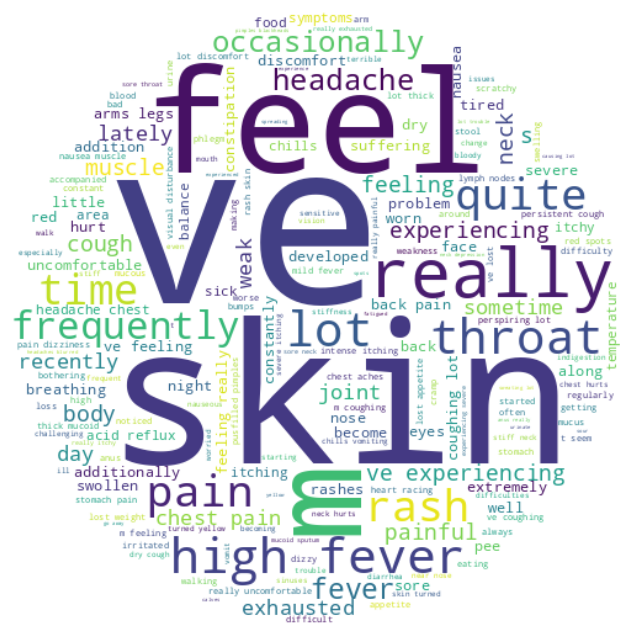

In [30]:
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

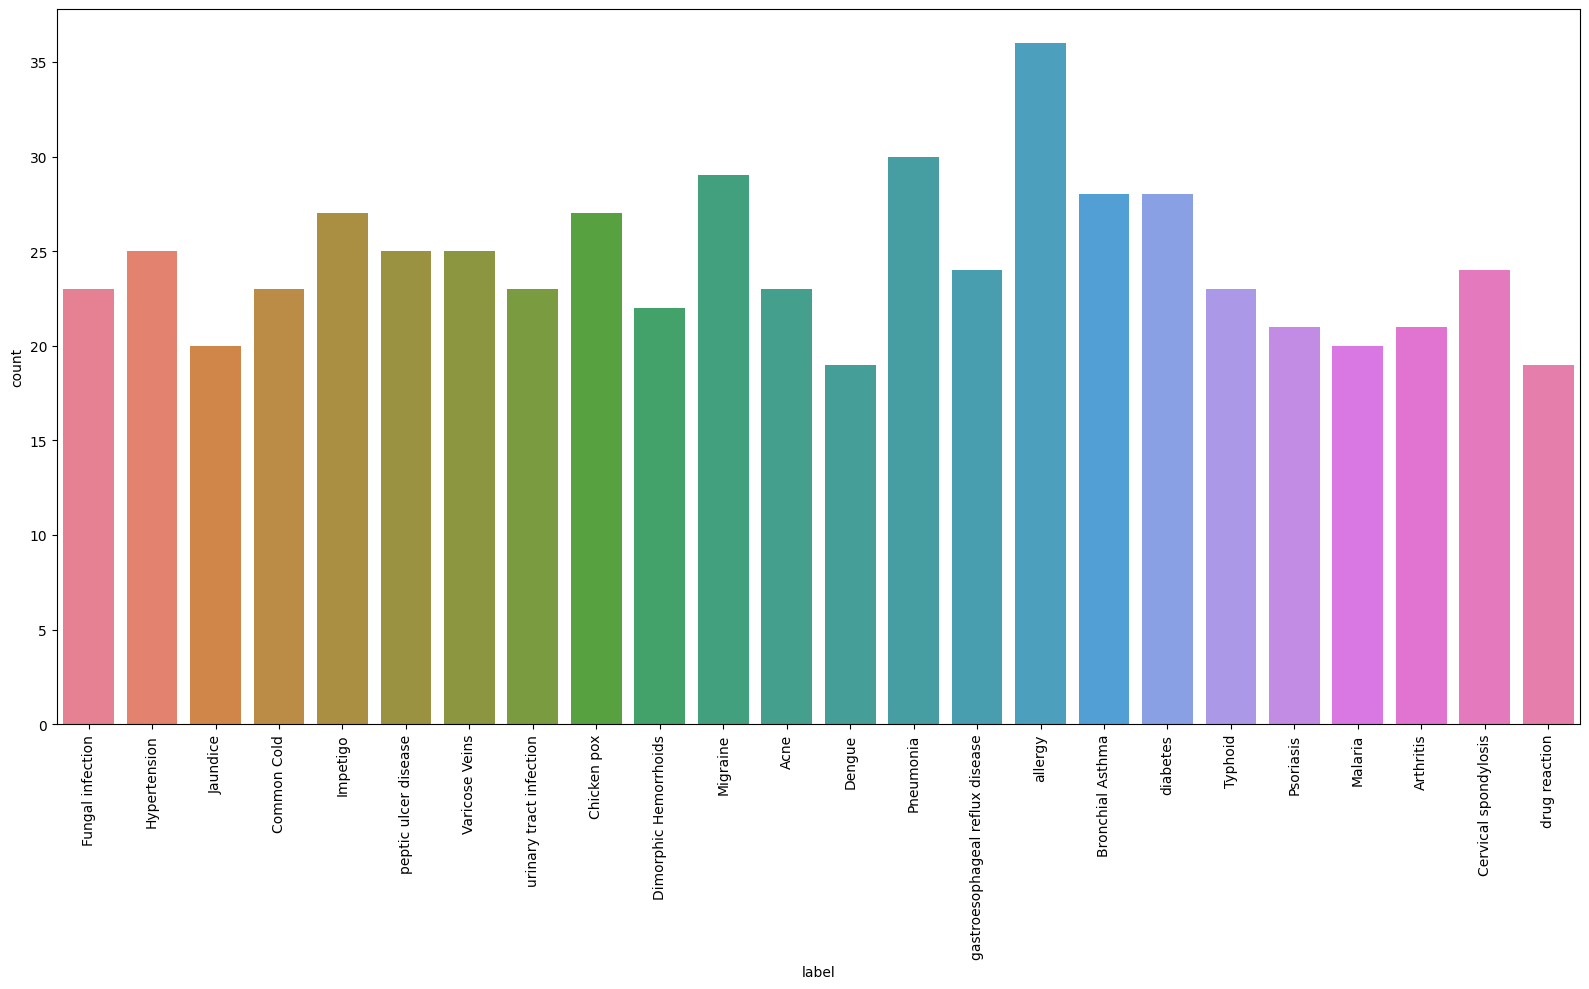

In [31]:
# Label distribution plot
plt.figure(figsize=(16, 10))
colors = sns.color_palette('husl', len(df['label'].unique()))
ax = sns.countplot(x='label', data=df, palette=colors)
plt.xticks(rotation=90)
plt.tight_layout()


In [32]:
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')
plt.show()

In [33]:
# Most frequent words analysis
from collections import Counter
corpus = []
for x in preprocessed_df['text'].str.split():
    corpus.extend(x)
counter = Counter(corpus)
most = counter.most_common()

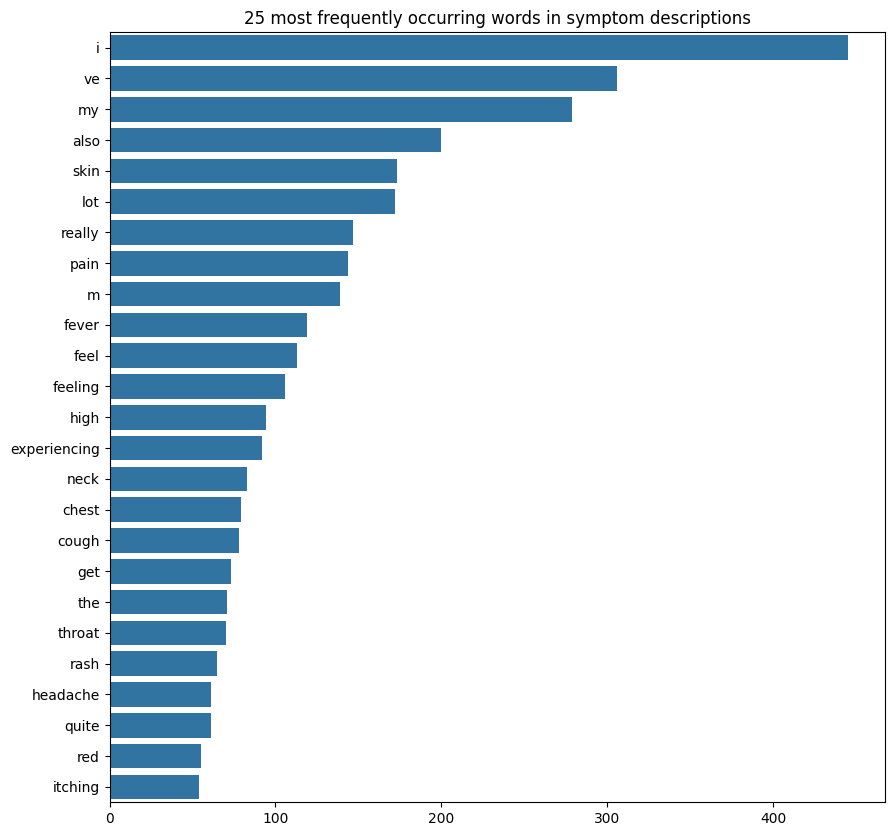

In [34]:
first_n = 25
words, counts = zip(*most[:first_n])
plt.figure(figsize=(10, 10))
sns.barplot(x=list(counts), y=list(words))
plt.title(f"{first_n} most frequently occurring words in symptom descriptions")
plt.show()


In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
import re
from PIL import Image, ImageDraw
from wordcloud import WordCloud
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Function to download NLTK resources with error handling
def download_nltk_resources():
    try:
        nltk.download('punkt', quiet=True)
        nltk.download('stopwords', quiet=True)
        # Additional Punkt resources needed
        nltk.download('punkt_tab', quiet=True)
        nltk.download('wordnet', quiet=True)
        nltk.download('omw-1.4', quiet=True)
    except Exception as e:
        print(f"Error downloading NLTK resources: {e}")
        print("Attempting to continue with available resources...")

# Download required NLTK data
download_nltk_resources()

# Verify Punkt tokenizer is available
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    print("Punkt tokenizer not found - some text processing may fail")
    try:
        nltk.download('punkt')
    except:
        print("Could not download Punkt tokenizer")

# [Rest of your original code continues here...]
# Include all your text cleaning functions, data loading, and modeling code
# from the previous solution

In [36]:
# Text preprocessing for modeling
def preprocess_text(text):
    words = word_tokenize(text.lower())
    words = [word for word in words if word.isalpha() and word not in stopwords.words('english')]
    return ' '.join(words)

preprocessed_symptoms = preprocessed_df['text'].apply(preprocess_text)

In [37]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=1500)
tfidf_features = tfidf_vectorizer.fit_transform(preprocessed_symptoms).toarray()

In [38]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    tfidf_features, df['label'], test_size=0.2, random_state=42)

In [39]:
# KNN Classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, y_train)

# Predictions
predictions = knn_classifier.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, predictions))

Accuracy: 0.80
                                 precision    recall  f1-score   support

                           Acne       0.60      1.00      0.75         3
                      Arthritis       1.00      1.00      1.00         5
               Bronchial Asthma       0.62      1.00      0.77         5
           Cervical spondylosis       1.00      1.00      1.00         8
                    Chicken pox       0.88      1.00      0.93         7
                    Common Cold       1.00      1.00      1.00         5
                         Dengue       0.50      0.50      0.50         4
          Dimorphic Hemorrhoids       1.00      1.00      1.00         5
               Fungal infection       1.00      1.00      1.00         5
                   Hypertension       0.50      1.00      0.67         1
                       Impetigo       1.00      1.00      1.00         3
                       Jaundice       0.83      1.00      0.91         5
                        Malaria    

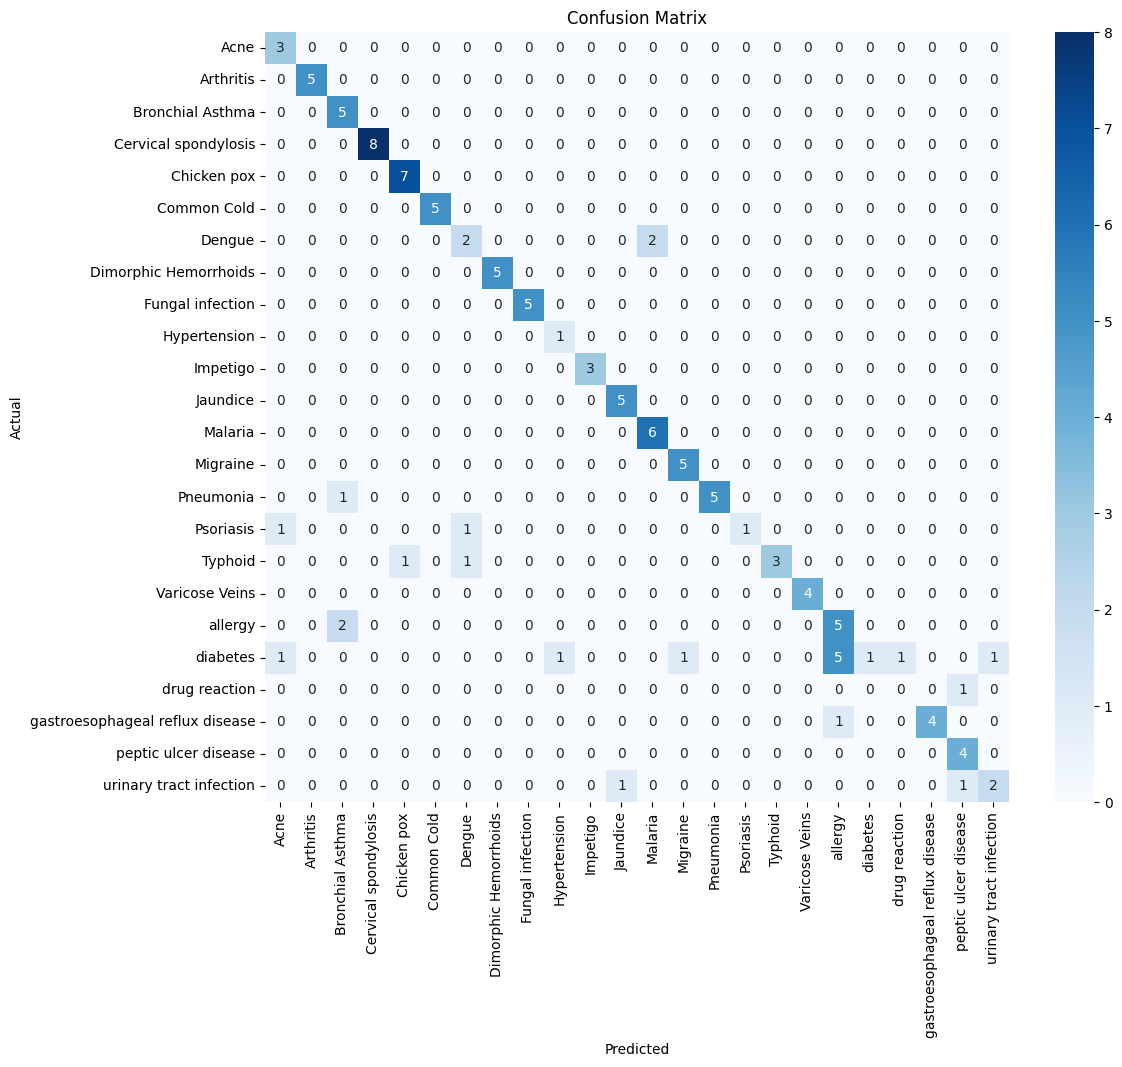

In [40]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(df['label']),
            yticklabels=np.unique(df['label']))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [41]:
# Example predictions
symptoms = [
    "Running nose, headache, throat pain",
    "Swollen lymph nodes, red spots",
    "fever headache body pain",
    "chest pain shortness of breath"
]

In [42]:
for symptom in symptoms:
    preprocessed_symptom = preprocess_text(symptom)
    symptom_tfidf = tfidf_vectorizer.transform([preprocessed_symptom])
    predicted_disease = knn_classifier.predict(symptom_tfidf)
    print(f"Symptoms: {symptom}")
    print(f'Predicted Disease: {predicted_disease[0]}\n')

Symptoms: Running nose, headache, throat pain
Predicted Disease: allergy

Symptoms: Swollen lymph nodes, red spots
Predicted Disease: Chicken pox

Symptoms: fever headache body pain
Predicted Disease: Chicken pox

Symptoms: chest pain shortness of breath
Predicted Disease: Bronchial Asthma



In [ ]:
import pickle

In [ ]:
with open('symptom_classifier.pkl', 'wb') as f:
    pickle.dump({
        'model': knn_classifier,
        'vectorizer': tfidf_vectorizer,
        'preprocess_text': preprocess_text,
        'clean_text': clean_text
    }, f)
    print("Model saved as symptom_classifier.pkl")


Model saved as symptom_classifier.pkl
